In [1]:
import numpy as np
import scipy as sp

N = 2
Mu = np.zeros((N, 1))
r = .6
Sigma = (1-r) * np.eye(N) + r * np.ones((N,N))

J = int(1e6)
p = np.ones((N,1)) / J
dd = np.random.multivariate_normal(Mu.reshape(N), Sigma, size=int(J/2))
X = np.ones((J,1)) * Mu.T + np.concatenate((dd, -dd), axis=0)

In [110]:
# Views

Q = np.matrix([1, -1])
Mu_Q = .5

G = np.matrix([-1, 1])
Sigma_G = .5 ** 2



In [111]:
def prior2posterior(mu, q, mu_q, sigma, g, sigma_g):
    """
    Analytical solution to the constrain
    X ~ (Mu, Sigma)
    E(QX) = Mu_Q
    Cov(GX) = Sigma_G
    
    minimize the KL divergence
    
    X ~ (Mu_tilda, Sigma_tilda)
    
    See the following paper for more details.

    Meucci, Attilio, Fully Flexible Views: Theory and Practice (August 8, 2008). 
    Fully Flexible Views: Theory and Practice, Risk, Vol. 21, No. 10, pp. 97-102, October 2008. 
    Available at SSRN: https://ssrn.com/abstract=1213325
    
    
    """
    mu_tilda = sigma * q.T * np.linalg.inv(q * sigma * q.T) * (mu_q - q * mu)
    tmp = np.linalg.inv(g * sigma * g.T)
    sigma_tilda = sigma + (sigma * g.T) * (tmp * sigma_g * tmp - tmp) * (g*sigma)
    return mu_tilda, sigma_tilda

In [114]:
Mu_tilda, Sigma_tilda = prior2posterior(Mu, Q, Mu_Q, Sigma, G, Sigma_G)

In [2]:
import seaborn
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

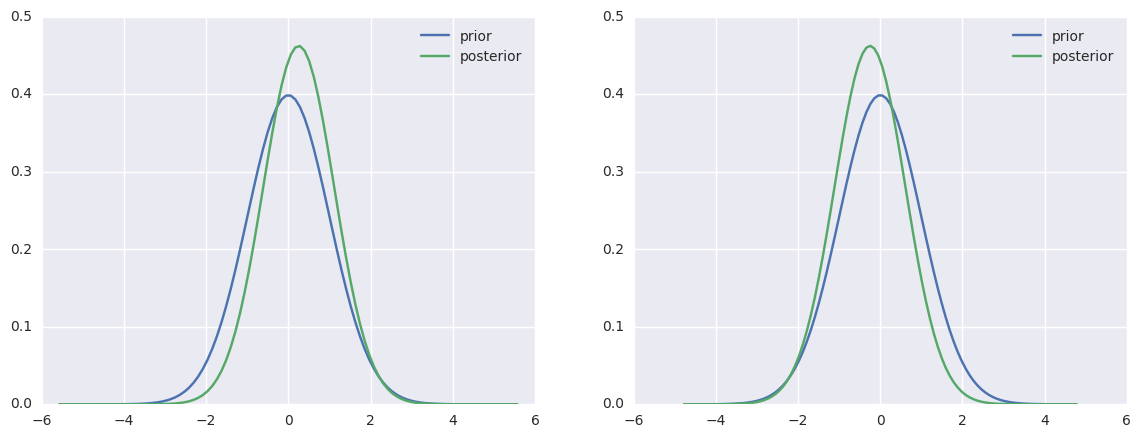

In [156]:
# analytical posterior distribution

n = 0
plt.figure(figsize=(14, 5));
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[:1,:1])
ax2 = plt.subplot(gs[:1, 1:2])

for n in range(2):
    xl = min(X[:, n])
    xh = max(X[:, n])
    x = np.linspace(xl, xh, 100)
    posterior_pdf = mlab.normpdf(x, np.array(Mu_tilda).reshape(N)[n], Sigma_tilda[n,n])
    prior_pdf = mlab.normpdf(x, Mu.reshape(N)[n], Sigma[n,n])

    # prior distribution

    
    if n == 0:
        ax1.plot(x, prior_pdf);
        ax1.plot(x, posterior_pdf);
        ax1.legend(['prior', 'posterior'])
    if n == 1:
        ax2.plot(x, prior_pdf);
        ax2.plot(x, posterior_pdf);
        ax2.legend(['prior', 'posterior'])

In [158]:
# numerical solution


Aeq = np.ones((1, J))
beq = 1

QX = X * Q.T

In [5]:
import numpy as np
import scipy.stats
import scipy.io
import scipy.optimize as spo
%matplotlib inline

In [40]:
def kde_scipy(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = scipy.stats.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde

def kernelbw(x):
    n = len(x)
    prop = 1.0
    sig = np.std(x)
    iqrSig = 0.7413 * scipy.stats.iqr(x)
    if iqrSig == 0:
        iqrSig = sig
    bw = prop * min(sig, iqrSig) * n ** (-1/(4+1))
    return bw

def kernelpdf(x, xi, wi):
    n = len(xi)
    bw = kernelbw(xi)
    
    p = np.zeros(len(x))
    for i in range(n):
        p = p + wi[i] * scipy.stats.norm.pdf(x, loc=xi[i], scale = bw);
    return p

def kernelcdf(x, xi, wi):
    n = len(xi)
    bw = kernelbw(xi)
    if type(x) is not np.ndarray:
        p = np.zeros(1)
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p[0]
    else:
        p = np.zeros(len(x))
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p

def kernelinv(p, xi, wi):
    import collections
    
    def helper(x, xi, wi, p):
        f = kernelcdf(x, xi, wi) - p
        return f

    if not isinstance(p, collections.Iterable):
        sortp = p
        x = spo.newton(helper, x0 = 1, args=(xi, wi, sortp))
        return x
    elif len(p) < 10:
        x = np.zeros(len(p))
        tmp = spo.newton(helper, x0 = 1, args=(xi, wi, p[0]))
        for i in range(len(p)):
            x[i] = tmp
        return x
    else:
        sortp = np.sort(p)
        x_min = spo.newton(helper, x0 = 1, args=(xi, wi, sortp[0]))
        x_max = spo.newton(helper, x0 = 1, args=(xi, wi, sortp[len(sortp)-1]))
    
        # mesh for x values
        x_ = np.linspace(x_min - 0.1 * abs(x_min), x_max + 0.1 * abs(x_max), 500)

        # evaluates the mesh on these values
        y_ = kernelcdf(x_, xi, wi);
        x = np.interp(p, y_, x_)
        return x

In [41]:
kernelinv(0.02, xi, wi)

-6.8765252107089312

In [47]:
xi = 100 * np.array([x[0][0] for x in scipy.io.loadmat('pseudodata.mat')['data'][:,1]])
n = len(xi)


# bandwith
bw = kernelbw(xi);

# weights
lamb = np.log(2) / (n / 2);
wi = np.exp(-lamb * np.array(range(n)))
wi = np.array(list(reversed(wi))) / sum(wi)


mu = np.mean(xi)
pdf = lambda x: kernelpdf(x, xi, wi)
cdf = lambda x: kernelcdf(x, xi, wi)
inv = lambda x: kernelinv(x, xi, wi)
VaR95 = inv(0.05)

J = 1000
tmp = np.linspace(0, 1, 1000)
epsilon = 1e-10
Lower = inv(epsilon)
Upper = inv(1 - epsilon)
X = Lower + tmp * (Upper - Lower)

p = np.array([1/J for _ in range(J)])

In [46]:
# Constraints


array([ -1.47227974e+01,  -1.46945713e+01,  -1.46663452e+01,
        -1.46381192e+01,  -1.46098931e+01,  -1.45816670e+01,
        -1.45534409e+01,  -1.45252149e+01,  -1.44969888e+01,
        -1.44687627e+01,  -1.44405366e+01,  -1.44123106e+01,
        -1.43840845e+01,  -1.43558584e+01,  -1.43276324e+01,
        -1.42994063e+01,  -1.42711802e+01,  -1.42429541e+01,
        -1.42147281e+01,  -1.41865020e+01,  -1.41582759e+01,
        -1.41300498e+01,  -1.41018238e+01,  -1.40735977e+01,
        -1.40453716e+01,  -1.40171455e+01,  -1.39889195e+01,
        -1.39606934e+01,  -1.39324673e+01,  -1.39042412e+01,
        -1.38760152e+01,  -1.38477891e+01,  -1.38195630e+01,
        -1.37913369e+01,  -1.37631109e+01,  -1.37348848e+01,
        -1.37066587e+01,  -1.36784327e+01,  -1.36502066e+01,
        -1.36219805e+01,  -1.35937544e+01,  -1.35655284e+01,
        -1.35373023e+01,  -1.35090762e+01,  -1.34808501e+01,
        -1.34526241e+01,  -1.34243980e+01,  -1.33961719e+01,
        -1.33679458e+01,

In [161]:
np.log(scipy.stats.norm.cdf([1,2,3], loc=xi[0], scale=bw)) + np.exp(np.log(wi[0]))

array([-0.23487222, -0.05291286, -0.00331611])

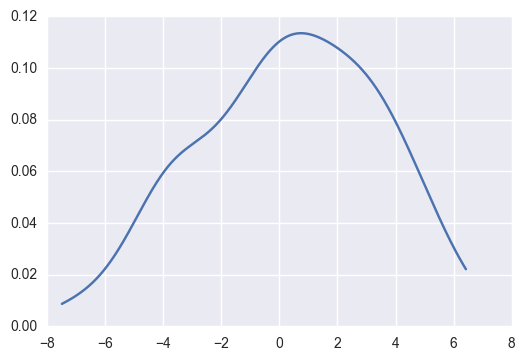

In [96]:
function [p] = kernelcdf(x, xi, bw, wi)

n = length(xi);
if nargin < 4 || isempty(wi)
   wi = ones(n, 1) / n;
end

if nargin < 3; bw = kernelbw(xi); end

p = zeros(size(x));
for i = 1:n
    p = p + exp(log(wi(i)) + log(normcdf(x, xi(i), bw)));
end

end